In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier

from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score

from sklearn.metrics import confusion_matrix, roc_curve, f1_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict
import collections

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import re
import warnings
import scikitplot as skplt
warnings.filterwarnings("ignore")

In [2]:
PPP_data = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\PPP_Projects_Total.csv")

In [3]:
PPP_Energy = PPP_data[PPP_data.sector == "Energy"]
PPP_ICT = PPP_data[PPP_data.sector == "ICT"]
PPP_Transport = PPP_data[PPP_data.sector == "Transport"]
PPP_Water = PPP_data[PPP_data.sector == "Water and sewerage"]

In [4]:
print("shape of energy sector: ", PPP_Energy.shape)
print("shape of ICT sector: ", PPP_ICT.shape)
print("shape of transport sector: ", PPP_Transport.shape)
print("shape of water sector: ", PPP_Water.shape)

shape of energy sector:  (3599, 44)
shape of ICT sector:  (134, 44)
shape of transport sector:  (1893, 44)
shape of water sector:  (1052, 44)


In [5]:
#1.PPI database
PPP_data = PPP_Transport
#add experience
country_experience = PPP_data.groupby(['countrycode', 'IY']).size().reset_index().sort_values(['countrycode', 'IY'])
country_experience.columns = ['countrycode', 'IY', 'experience']
unique_country = country_experience.countrycode.unique()
years = np.arange(1990, 2020)

for country in unique_country:
    for year in years:
        if year not in country_experience.loc[country_experience.countrycode==country, 'IY'].values:
            country_experience = country_experience.append({'countrycode': country, 'IY': year, 'experience': 0}, ignore_index=True)

country_experience = country_experience.sort_values(by=['countrycode', 'IY']).set_index(np.arange(country_experience.shape[0]))
country_experience['cum_experience'] = country_experience.groupby('countrycode')['experience'].cumsum()
country_experience.drop(columns=['experience'], inplace=True)

country_experience['shifted_country_experience_1'] = country_experience.groupby('countrycode')['cum_experience'].shift(1).fillna(method='bfill')
country_experience.drop(columns=['cum_experience'], inplace=True)

In [6]:
country_experience

,countrycode,IY,shifted_country_experience_1
0,AGO,1990,0.0
1,AGO,1991,0.0
2,AGO,1992,0.0
3,AGO,1993,0.0
4,AGO,1994,0.0
...,...,...,...
2545,ZWE,2015,2.0
2546,ZWE,2016,2.0
2547,ZWE,2017,2.0
2548,ZWE,2018,2.0


In [7]:
country_sector_experience = PPP_data.groupby(['countrycode', 'IY', 'ssector']).size().reset_index().sort_values(['countrycode', 'IY'])
country_sector_experience.columns = ['countrycode', 'IY', 'ssector', 'ssector_experience']
unique_sector_country = country_sector_experience.countrycode.unique()
unique_sector = country_sector_experience.ssector.unique()
years = np.arange(1990, 2020)

for country in unique_sector_country:
    for year in years:
        if year not in country_sector_experience.loc[country_sector_experience.countrycode==country, 'IY'].values:
            for sectors in unique_sector:
                country_sector_experience = country_sector_experience.append({'countrycode': country, 
                                                                              'IY': year, 
                                                                              'ssector': sectors, 
                                                                              'ssector_experience': 0}, ignore_index=True)
        else:
            for sectors in unique_sector:
                if sectors not in country_sector_experience.loc[(country_sector_experience.countrycode==country) & (country_sector_experience.IY==year),
                                                                'ssector'].values:
                    country_sector_experience = country_sector_experience.append({'countrycode': country, 
                                                                                  'IY': year, 
                                                                                  'ssector': sectors, 
                                                                                  'ssector_experience': 0}, ignore_index=True)

country_sector_experience = country_sector_experience.sort_values(by=['countrycode', 'IY']).set_index(np.arange(country_sector_experience.shape[0]))
country_sector_experience['cum_ssector_experience'] = country_sector_experience.groupby(['countrycode', 'ssector'])['ssector_experience'].cumsum()
country_sector_experience.drop(columns=['ssector_experience'], inplace=True)

country_sector_experience['shifted_ssector_experience_1'] = country_sector_experience.groupby(['countrycode', 'ssector'])['cum_ssector_experience'].shift(1).fillna(method='bfill')
country_sector_experience.drop(columns=['cum_ssector_experience'], inplace=True)

In [8]:
country_sector_experience

,countrycode,IY,ssector,shifted_ssector_experience_1
0,AGO,1990,Seaports,0.0
1,AGO,1990,Airports,0.0
2,AGO,1990,Toll Roads,0.0
3,AGO,1990,Railroads,0.0
4,AGO,1991,Seaports,0.0
...,...,...,...,...
10195,ZWE,2018,Railroads,1.0
10196,ZWE,2019,Seaports,0.0
10197,ZWE,2019,Airports,0.0
10198,ZWE,2019,Toll Roads,1.0


In [9]:
PPP_data = PPP_data.merge(country_experience,
                          left_on=['countrycode', 'IY'],
                          right_on=['countrycode', 'IY'],
                          how='left')

In [10]:
PPP_data.shape

(1893, 45)

In [11]:
PPP_data = PPP_data.merge(country_sector_experience,
                          left_on=['countrycode', 'IY', 'ssector'],
                          right_on=['countrycode', 'IY', 'ssector'],
                          how='left')

In [12]:
PPP_data.shape

(1893, 46)

In [13]:
PPP_data.loc[:, 'PCO'] = PPP_data['PCO'].str.replace('\n', '') 
PPP_data.loc[~PPP_data.PCO.isnull() & (PPP_data.PCO != ''), 
             'sponsor_number'] = PPP_data[~PPP_data.PCO.isnull() & (PPP_data.PCO != '')].PCO.str.split('/').map(lambda x: x[2])
PPP_data.sponsor_number = PPP_data.sponsor_number.replace('', np.nan)

PPP_data.loc[~PPP_data.PCO.isnull() & (PPP_data.PCO != ''), 
             'foreign_country'] = PPP_data[~PPP_data.PCO.isnull() & (PPP_data.PCO != '')].PCO.str.split('/').map(lambda x: x[1])

PPP_data.foreign_country = PPP_data.foreign_country.replace('N', 'No')
PPP_data.loc[(PPP_data.foreign_country!='No') & (~PPP_data.foreign_country.isnull()), 'foreign_country'] = 'Yes'

In [14]:
PPP_data.shape

(1893, 48)

In [15]:
#2.GDP per capita
GDP_per_capita = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP per Capita.csv")
#3.Tax as GDP
tax_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Tax as GDP.csv")
#4.GDP deflator(inflation rate)
GDP_deflator = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP deflator.csv")
#5.life expectnacy
life_expectnacy = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Life expectnacy.csv")
#6.real effective change
real_effective_change = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Real effect change.csv")
#7.electric consumption
electric_consumption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Electric consumption.csv")
#8.domestic credit to private
domestic_credit_to_private = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Domestic credit to private.csv")
#9.Import as GDP
imports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Imports as GDP.csv")
#10.Export as GDP
exports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Exports as GDP.csv")
#11.Control of corruption
control_of_corruption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Control of corruption.csv", encoding='cp1252')
#12.Government of effectiveness
government_effectiveness = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Government effectiveness.csv", encoding='cp1252')
#13.Political stability
political_stability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Political Stability and Absence of Violence.csv", encoding='cp1252')
#14.regulatory quality
regulatory_quality = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Regulatory quality.csv", encoding='cp1252')
#15.Rule of law
rule_of_law = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Rule of law.csv", encoding='cp1252')
#16.voice and accountability
voice_and_accountability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Voice and accountability.csv", encoding='cp1252')

dataset = [GDP_per_capita, 
           tax_as_GDP, 
           GDP_deflator, 
           life_expectnacy, 
           real_effective_change,
           electric_consumption,
           domestic_credit_to_private, 
           imports_as_GDP, 
           exports_as_GDP, 
           control_of_corruption,
           government_effectiveness, 
           political_stability, 
           regulatory_quality, 
           rule_of_law, 
           voice_and_accountability]

dataset_name = ['GDP_per_capita', 
                'tax_as_GDP', 
                'GDP_deflator', 
                'life_expectnacy', 
                'real_effective_change',
                'electric_consumption', 
                'domestic_credit_to_private', 
                'imports_as_GDP', 
                'exports_as_GDP', 
                'control_of_corruption',
                'government_effectiveness',
                'political_stability', 
                'regulatory_quality', 
                'rule_of_law', 
                'voice_and_accountability']

def process_data(original_data):
    new_data = original_data.copy()
    new_data.replace('..', np.nan, inplace=True)
    new_data.drop(columns=['Series Name', 'Series Code', 'Country Name'], inplace=True)
    new_data.set_index('Country Code', inplace=True)
    new_data.dropna(how='all', inplace=True)
    new_data.columns = [name.split(' ')[0] for name in list(new_data.columns)]
    new_data = new_data.fillna(axis=1, method='bfill')
    new_data = new_data.fillna(axis=1, method='ffill')
    return new_data

for i in np.arange(len(dataset)):
    dataset[i] = process_data(dataset[i])

def meltdata(raw_data, column_name):
    new_data = pd.melt(raw_data.reset_index(), 
                       id_vars=['Country Code'], 
                       var_name=['Year'],
                       value_vars=raw_data.columns,
                       value_name=column_name)   
    new_data.Year = new_data.Year.astype('int64', copy=False)
    return new_data

for i,name in zip(np.arange(len(dataset)), dataset_name):
    dataset[i] = meltdata(dataset[i], name).copy()
    dataset[i].rename(columns={'Country Code': 'countrycode', 
                               'Year': 'IY'}, 
                      inplace=True)
    dataset[i][name] = dataset[i].groupby('countrycode')[name].shift(1).fillna(method='bfill')

for data in dataset:
    PPP_data= PPP_data.merge(data, 
                             left_on=['countrycode', 'IY'], 
                             right_on=['countrycode', 'IY'], 
                             how='left')

In [16]:
PPP_data.shape

(1893, 63)

In [17]:
PPP_data.head(5)

,IY,country,Region,income,IDA,FCY,type,stype,status_n,sector,...,electric_consumption,domestic_credit_to_private,imports_as_GDP,exports_as_GDP,control_of_corruption,government_effectiveness,political_stability,regulatory_quality,rule_of_law,voice_and_accountability
0,1990,Argentina,LAC,Upper middle income,Non-IDA,1/9/1990,Brownfield,"Rehabilitate, operate, and transfer",Active,Transport,...,1320.35657186199,39.7174950191489,6.57938879331971,13.0584089085641,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
1,1990,Mexico,LAC,Upper middle income,Non-IDA,1/11/1990,Greenfield project,"Build, operate, and transfer",Active,Transport,...,1232.47927061236,21.2478867299859,19.1974507744512,19.1321993029959,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
2,1990,Thailand,EAP,Upper middle income,Non-IDA,1/12/1990,Management and lease contract,Lease contract,Active,Transport,...,614.948290786396,106.362551068585,37.4854054733393,34.9215280475186,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
3,1990,Mexico,LAC,Upper middle income,Non-IDA,1/12/1990,Greenfield project,"Build, operate, and transfer",Active,Transport,...,1232.47927061236,21.2478867299859,19.1974507744512,19.1321993029959,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
4,1990,Mexico,LAC,Upper middle income,Non-IDA,1/3/1990,Greenfield project,"Build, operate, and transfer",Active,Transport,...,1232.47927061236,21.2478867299859,19.1974507744512,19.1321993029959,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854


In [18]:
#copy data out.
data = PPP_data.copy()
data.drop(columns=['country',
                   'regionname',                   
                   'region',
                   'adminregionname',
                   'Description',
                   'FCY',
                   'bid_crit',
                   'incomelevelname',
                   'lendingtypename',
                   'TIGS',
                   'PCO',
                   'sector',
                   'shareborder',
                   'GDP',
                   'population',
                   'investment_real',
                   'realphysicalassets',
                   'income'], inplace=True)

data.replace('..', np.nan, inplace=True)

data.replace({'status_n': {'Cancelled': 'fail', 
                           'Distressed': 'fail', 
                           'Active': 'success',
                           'Concluded': 'success'}}, inplace=True)

float_value = ['GDP_per_capita', 
               'tax_as_GDP', 
               'GDP_deflator', 
               'life_expectnacy', 
               'real_effective_change',
               'electric_consumption', 
               'domestic_credit_to_private', 
               'imports_as_GDP', 
               'exports_as_GDP', 
               'control_of_corruption',
               'government_effectiveness', 
               'political_stability', 
               'regulatory_quality', 
               'rule_of_law', 
               'voice_and_accountability',
               'shifted_country_experience_1',
               'shifted_ssector_experience_1',
               'period',
               'CPI2019',
               'bordercountries', 
               'private', 
               'physical', 
               'period',
               'investment', 
               'pcapacity',
               'sponsor_number',
               'IY']
nominal_value = ['IDA', 
                 'Region',
                 'type', 
                 'stype', 
                 'ssector',
                 'Segment', 
                 'UP', 
                 'PublicDisclosure', 
                 'PRS', 
                 'Renewables', 
                 'MLS', 
                 'GGC',
                 'BS',
                 'lendingtype'
                 'adminregion',
                 'foreign_country']
ordinal_value = ['incomelevel']

for float_column in float_value:
    data[float_column] = data[float_column].astype(float)

In [19]:
data.shape

(1893, 45)

In [20]:
data.head(10)

,IY,Region,IDA,type,stype,status_n,ssector,Segment,period,GGC,...,electric_consumption,domestic_credit_to_private,imports_as_GDP,exports_as_GDP,control_of_corruption,government_effectiveness,political_stability,regulatory_quality,rule_of_law,voice_and_accountability
0,1990.0,LAC,Non-IDA,Brownfield,"Rehabilitate, operate, and transfer",success,Toll Roads,Highway,28.0,NaN,...,1320.356572,39.717495,6.579389,13.058409,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
1,1990.0,LAC,Non-IDA,Greenfield project,"Build, operate, and transfer",success,Toll Roads,Highway,30.0,NaN,...,1232.479271,21.247887,19.197451,19.132199,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
2,1990.0,EAP,Non-IDA,Management and lease contract,Lease contract,success,Seaports,Runway and terminal,27.0,NaN,...,614.948291,106.362551,37.485405,34.921528,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
3,1990.0,LAC,Non-IDA,Greenfield project,"Build, operate, and transfer",success,Toll Roads,Highway,60.0,NaN,...,1232.479271,21.247887,19.197451,19.132199,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
4,1990.0,LAC,Non-IDA,Greenfield project,"Build, operate, and transfer",success,Toll Roads,Highway,30.0,NaN,...,1232.479271,21.247887,19.197451,19.132199,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
5,1990.0,LAC,Non-IDA,Brownfield,"Build, rehabilitate, operate, and transfer",success,Toll Roads,Highway,31.0,NaN,...,1232.479271,21.247887,19.197451,19.132199,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
6,1990.0,EAP,Non-IDA,Management and lease contract,Lease contract,success,Seaports,Runway and terminal,27.0,NaN,...,614.948291,106.362551,37.485405,34.921528,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
7,1990.0,EAP,Non-IDA,Greenfield project,"Build, operate, and transfer",success,Toll Roads,Highway,33.0,NaN,...,487.373173,77.133290,13.261366,11.844329,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
8,1990.0,LAC,Non-IDA,Brownfield,"Build, rehabilitate, operate, and transfer",success,Toll Roads,Highway,25.0,State/Provincial,...,1320.356572,39.717495,6.579389,13.058409,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854
9,1990.0,SAR,Non-IDA,Brownfield,"Build, rehabilitate, operate, and transfer",success,Toll Roads,Highway,NaN,NaN,...,257.039736,26.589814,8.152002,7.016130,-1.291705,-2.175167,-2.414042,-2.09033,-1.788075,-1.90854


In [21]:
# BS (Bilateral Support) replace with NO and Yes, 
data.loc[(data.BS!='No') & (~data.BS.isnull()), 'BS'] = 'Yes'
#private convert to categorical data.
#physical, investment, pcapacity will be converted to np.log
to_log = ['physical', 'investment', 'pcapacity']
for column in to_log:
    data[column] = np.log(data[column] + 0.01)

In [22]:
#split the data
X = data[data.columns[data.columns!='status_n']]
y = data['status_n']
#income value is ordinal value
mapper = {'LIC': 1, 
          'HIC': 4, 
          'LMC': 2, 
          'UMC': 3}
X.loc[:, 'incomelevel'] = X.incomelevel.map(mapper)

predicted_status = {'success': 0, 
                    'fail': 1}
y = y.map(predicted_status)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y, shuffle=True)

In [32]:
print("shape of train dataset: ", X_train.shape)
print("shape of test dataset: ", X_test.shape)
print("imbalance rate of train dataset: ", y_train.sum()/y_train.shape)
print("imbalance rate of test dataset: ", y_test.sum()/y_test.shape)
print("failure projects of train dataset: ", y_train.sum())
print("failure projects of test dataset: ", y_test.sum())

shape of train dataset:  (1419, 44)
shape of test dataset:  (474, 44)
imbalance rate of train dataset:  [0.05990134]
imbalance rate of test dataset:  [0.06118143]
failure projects of train dataset:  85
failure projects of test dataset:  29


In [35]:
from sklearn.base import BaseEstimator

class FillMissing(BaseEstimator):
    def __init__(self, feature_name):
        print('\n......... init() called.\n')
        self.feature_name = feature_name
    def fit(self, X, y=None):
        print('\n......... fit() called.\n')
        return self
    def transform(self, X, y=None):
        print('\n.......... transform () called.\n')
        X_ = X.copy()
        X_[self.feature_name] = 
        
    
    

In [33]:
def fillna_nominal(train_dataset, test_dataset, group_list, column):
    train = train_dataset.copy()
    test = test_dataset.copy()
    mode_in_train = train.groupby(group_list)[column].agg(pd.Series.mode).to_frame().reset_index()
    # if no mode for current group, then fill with the mode in current column.
    for index, row in mode_in_train.iterrows():
        if type(row[column]) == np.ndarray:
            mode_in_train.loc[index, column] = train[column].mode()[0]
    for i, rows in mode_in_train.iterrows():
        train_index = (train[group_list[0]] == rows[group_list[0]])
        test_index = (test[group_list[0]] == rows[group_list[0]])
        for t in np.arange(len(group_list)):
            train_index = train_index & (train[group_list[t]] == rows[group_list[t]])
            test_index = test_index & (test[group_list[t]] == rows[group_list[t]])
        train.loc[train_index, column] = train.loc[train_index, column].fillna(rows[column])
        test.loc[test_index, column] = test.loc[test_index, column].fillna(rows[column])
        
    train.loc[:, column] = train[column].fillna(train[column].mode()[0])
    test.loc[:, column] = test[column].fillna(train[column].mode()[0])       
    return train, test
def fillna_numerical(train_dataset, test_dataset, group_list, column):
    train = train_dataset.copy()
    test = test_dataset.copy()
    mean_in_train = train.groupby(group_list)[column].mean().to_frame().reset_index()
    for i, rows in mean_in_train.iterrows():
        train_index = (train[group_list[0]] == rows[group_list[0]])
        test_index = (test[group_list[0]] == rows[group_list[0]])
        for t in np.arange(len(group_list)):
            train_index = train_index & (train[group_list[t]] == rows[group_list[t]])
            test_index = test_index & (test[group_list[t]] == rows[group_list[t]])
        train.loc[train_index, column] = train.loc[train_index, column].fillna(rows[column])
        test.loc[test_index, column] = test.loc[test_index, column].fillna(rows[column])
        
    train.loc[:, column] = train[column].fillna(train[column].mean())
    test.loc[:, column] = test[column].fillna(train[column].mean())
    return train, test   

In [34]:
missing_categorical = {'lendingtype': ['countrycode', 'ssector'],
                       'GGC': ['countrycode', 'ssector'],
                       'PRS': ['countrycode', 'ssector'],
                       'BS': ['countrycode', 'ssector'],
                       'adminregion': ['Region'],
                       'incomelevel': ['Region'],
                       'foreign_country': ['countrycode', 'ssector']}

for column, group_list in missing_categorical.items():
    if (X_train[column].isnull().sum() != 0) | (X_test[column].isnull().sum() != 0):
        X_train, X_test = fillna_nominal(X_train, X_test, group_list, column)

missing_numerical = {'period': ['stype', 'Region', 'countrycode'],
                     'pcapacity': ['stype', 'Region', 'countrycode'],
                     'private': ['stype', 'ssector', 'countrycode'],
                     'physical': ['stype', 'ssector', 'countrycode'],
                     'investment': ['stype', 'ssector', 'countrycode'],
                     'tax_as_GDP': ['Region'],
                     'real_effective_change': ['Region'],
                     'domestic_credit_to_private': ['Region'],
                     'rule_of_law': ['Region'],
                     'imports_as_GDP': ['Region'],
                     'exports_as_GDP': ['Region'],
                     'electric_consumption': ['Region'],
                     'sponsor_number': ['countrycode', 'ssector']}

for column, group_list in missing_numerical.items():
    if (X_train[column].isnull().sum() != 0) | (X_test[column].isnull().sum() != 0):
        X_train, X_test = fillna_numerical(X_train, X_test, group_list, column)

In [72]:
X_train.drop(columns=['countrycode'], inplace=True)
X_test.drop(columns=['countrycode'], inplace=True)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [74]:
#to make sure the train and test dataset have the same shape
train_objs_num = len(X_train)
combine_dataset = pd.concat(objs=[X_train, X_test], axis=0)
dataset_preprocessed = pd.get_dummies(combine_dataset, columns=X_train.columns[X_train.dtypes == object], drop_first=True)
X_train = dataset_preprocessed[:train_objs_num]
X_test = dataset_preprocessed[train_objs_num:]
#scaling data
scaler = RobustScaler()
numeric_column = X_train.columns[X_train.dtypes == 'float64']
X_train[numeric_column] = scaler.fit_transform(X_train[numeric_column])
X_test[numeric_column] = scaler.transform(X_test[numeric_column])

In [89]:
X_train.drop(columns=['IY'], inplace=True)
X_test.drop(columns=['IY'], inplace=True)

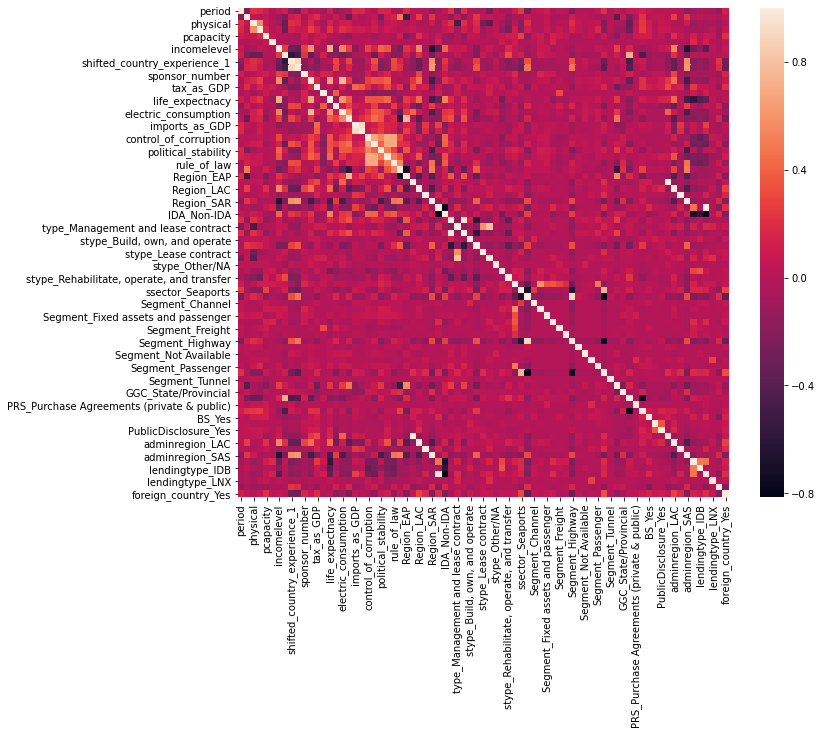

In [137]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(X_train.corr())

In [138]:
X_train.corr()

,period,private,physical,investment,pcapacity,bordercountries,incomelevel,CPI2019,shifted_country_experience_1,shifted_ssector_experience_1,...,adminregion_ECA,adminregion_LAC,adminregion_MNA,adminregion_SAS,adminregion_SSA,lendingtype_IDB,lendingtype_IDX,lendingtype_LNX,MLS_Without MLS,foreign_country_Yes
period,1.000000,-0.206704,0.207605,0.174520,0.094925,-0.020323,0.073129,0.116483,-0.166237,-0.233312,...,0.030342,0.019684,0.007923,-0.170894,-0.086647,-0.024593,-0.041250,-0.061061,-0.150707,0.122246
private,-0.206704,1.000000,0.062308,0.010487,0.064727,-0.030349,-0.113564,-0.220139,0.103726,0.157014,...,0.031077,0.264741,-0.021077,0.230992,0.002950,0.042081,-0.012843,0.018063,-0.047147,0.054041
physical,0.207605,0.062308,1.000000,0.574657,0.075736,0.014844,-0.065626,-0.341320,0.204547,0.166798,...,0.045198,-0.028868,-0.031976,0.099916,-0.120550,-0.033881,-0.089499,-0.034994,-0.098507,0.008028
investment,0.174520,0.010487,0.574657,1.000000,0.160611,-0.014737,0.050097,-0.314243,0.137889,0.083321,...,0.075697,0.012603,0.014063,-0.040577,-0.068618,-0.056851,-0.045334,0.034513,-0.094703,0.071777
pcapacity,0.094925,0.064727,0.075736,0.160611,1.000000,0.071444,0.018077,-0.004279,-0.058748,-0.078900,...,-0.111244,0.208111,0.068192,-0.022126,0.111137,0.013711,0.077500,0.057745,-0.139790,0.212060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lendingtype_IDB,-0.024593,0.042081,-0.033881,-0.056851,0.013711,-0.007426,-0.177097,0.017655,-0.136210,-0.105339,...,-0.016057,-0.108697,-0.021162,-0.043960,0.494518,1.000000,-0.035064,-0.006061,-0.040377,0.091410
lendingtype_IDX,-0.041250,-0.012843,-0.089499,-0.045334,0.077500,0.137860,-0.381300,0.004036,-0.187448,-0.145952,...,-0.033826,-0.087794,0.129503,-0.094127,0.466765,-0.035064,1.000000,-0.008165,-0.186438,0.193281
lendingtype_LNX,-0.061061,0.018063,-0.034994,0.034513,0.057745,-0.001729,0.024275,-0.012344,-0.032711,-0.025443,...,-0.008558,0.055764,-0.004928,-0.024031,-0.009364,-0.006061,-0.008165,1.000000,0.012082,0.061025
MLS_Without MLS,-0.150707,-0.047147,-0.098507,-0.094703,-0.139790,-0.037841,-0.036027,-0.022542,0.222443,0.189021,...,-0.161220,-0.127730,-0.070329,0.173741,-0.105310,-0.040377,-0.186438,0.012082,1.000000,-0.229897


In [90]:
X_bal, y_bal = SMOTE(sampling_strategy='minority',random_state=0).fit_resample(
    X_train,
    y_train)

X_bal = pd.DataFrame(X_bal, columns=X_train.columns)
y_bal = pd.DataFrame(y_bal, columns=['status_n'])
# ###########
balanced = X_bal.join(y_bal)
bal_corr = balanced.corr()

In [91]:
X_bal.shape

(2668, 77)

In [164]:
data_dict = {}
#0, 6, 0.02, 0.05, 6, 0.02
for threshold in [0.05]:
    for out in [3]:
        no_outliers = pd.DataFrame(balanced.copy())
        cols = bal_corr.status_n.index[:-1]
        for col in cols:
            correlation = bal_corr.loc['status_n', col]
            if np.abs(correlation) > threshold:
                nonfrauds = no_outliers.loc[no_outliers.status_n==0, col]
                frauds = no_outliers.loc[no_outliers.status_n==1, col]
        
                all_values = no_outliers.loc[:,col]
                q25, q75 = np.percentile(all_values, 25), np.percentile(all_values, 75)
                iqr = q75 - q25
                cutoff = iqr * out
                lower, upper = q25 - cutoff, q75 + cutoff
                if correlation > 0: 
                    no_outliers.drop(index=nonfrauds[nonfrauds>upper].index,inplace=True)
                    no_outliers.drop(index=frauds[frauds<lower].index,inplace=True)
                elif correlation < 0: 
                    no_outliers.drop(index=nonfrauds[nonfrauds<lower].index,inplace=True)
                    no_outliers.drop(index=frauds[frauds>upper].index,inplace=True)        
        for i in [0.02]:
            data_list = []
            key =(threshold, out, i)
            feat_sel =pd.DataFrame(no_outliers.copy())
            new_corr = feat_sel.corr()
            for col in new_corr.status_n.index[:-1]:
                if np.abs(new_corr.loc['status_n', col]) < i:
                    feat_sel.drop(columns=col, inplace=True)

            X_final_train = feat_sel.drop('status_n', 1)
            y_final_train = feat_sel.status_n
            X_final_train, y_final_train = SMOTE(sampling_strategy='minority',random_state=0).fit_resample(
                               X_final_train,
                               y_final_train)

            X_final_test = X_test[X_final_train.columns]
            y_final_test = y_test
            data_list.append([X_final_train, y_final_train, X_final_test, y_final_test])
            data_dict[key] = data_list

In [165]:
data_dict.get((0.05, 3, 0.02), 0)[0][0]

,private,physical,investment,pcapacity,bordercountries,incomelevel,CPI2019,shifted_country_experience_1,shifted_ssector_experience_1,GDP_per_capita,...,adminregion_ECA,adminregion_LAC,adminregion_MNA,adminregion_SAS,adminregion_SSA,lendingtype_IDB,lendingtype_IDX,lendingtype_LNX,MLS_Without MLS,foreign_country_Yes
0,0.000000,-1.892410,-2.339115,-1.315314,0.0,-1.000000,0.173971,0.074468,0.342342,-0.283223,...,0,0,0,1,0,0,0,0,1,0
1,0.000000,0.750928,0.924548,0.501971,0.0,0.000000,0.766787,-0.132979,-0.072072,0.612616,...,0,1,0,0,0,0,0,0,0,1
2,0.000000,0.339979,0.360650,0.132304,0.0,-1.000000,-0.491371,2.234043,3.612613,-0.022631,...,0,0,0,1,0,0,0,0,1,0
3,-22.546018,0.653024,0.739235,-0.481699,0.0,0.000000,-0.491365,1.212766,1.540541,1.516237,...,0,0,0,0,0,0,0,0,1,0
4,0.000000,1.114446,1.297260,0.291908,0.0,-1.000000,-0.273241,-0.180851,-0.009009,0.297151,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,0.000000,-0.206826,-0.167650,-0.413562,0.0,-0.496993,0.918780,-0.292329,-0.134756,-0.047404,...,0,0,0,0,0,0,0,0,1,0
2170,0.000000,-0.668509,-0.858977,-0.999624,0.0,-0.252044,1.097326,-0.312359,-0.168680,-0.111066,...,0,0,0,0,0,0,0,0,1,0
2171,0.000000,0.307751,0.357047,0.336136,0.0,-1.000000,-0.273241,1.409574,2.324324,-0.123403,...,0,0,0,1,0,0,0,0,1,0
2172,0.000000,-1.129014,-1.415894,-0.158062,0.0,0.056876,0.271442,0.000706,-0.119836,1.159963,...,0,1,0,0,0,0,0,0,1,0


In [97]:
def plot_roc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)   
    ax.plot(fpr, tpr, 'k', label = 'AUC = %0.2f' % roc_auc)
    ax.set_xlabel("True Positive Rate", fontsize=27, fontname='times new roman', labelpad=10)
    ax.set_ylabel("False Positive Rate", fontsize=27, fontname='times new roman', labelpad=4)
    ax.legend(loc='lower right', frameon=False, prop={'family':'Times new roman', 'size':20})
    ax.plot([0, 1], [0, 1],'r--')
    ax.tick_params(axis='both', length=7, labelsize=25, width=1.5, color='black')
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
    plt.savefig(r"C:\PPP\Thesis\Paper3\ROC.png", dpi=1000)

def plot_recall_precision(y_true, y_pred):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)   
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    ax.plot(recall, precision, 'k')
    no_skill = y_true.sum()/len(y_true)
    ax.plot([0, 1], [no_skill, no_skill], linestyle='--')
    ax.set_xlabel("Recall", fontsize=27, fontname='times new roman', labelpad=10)
    ax.set_ylabel("Precision", fontsize=27, fontname='times new roman', labelpad=4)
    ax.legend(frameon=False, prop={'family':'Times new roman', 'size':20})
    ax.tick_params(axis='both', length=7, labelsize=25, width=1.5, color='black')
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
    plt.savefig(r"C:\PPP\Thesis\Paper3\precision-recall.png", dpi=1000)


def plot_cm(labels, predictions, p):
    cm = confusion_matrix(labels, predictions > p)
    new_cm = np.array([[0, 0], [0, 0]])
    new_cm[0, 0] = cm[1, 1]
    new_cm[0, 1] = cm[0, 1]
    new_cm[1, 0] = cm[1, 0]
    new_cm[1, 1] = cm[0, 0]
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)  

    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    sns.heatmap(new_cm, annot=True, fmt='.0f', cmap=cmap, annot_kws={"size":20, 'fontname': 'times new roman'}, cbar=False)

    
    plt.yticks([0.5,1.5], [ 'fail', 'success'],va='center')
    plt.xticks([0.5,1.5], [ 'fail', 'success'],va='center')
    
    ax.set_xlabel("True label", fontsize=27, fontname='times new roman')
    ax.set_ylabel("Predicted result", fontsize=27, fontname='times new roman')
    
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=10)
    ax.tick_params(axis='both', length=0, labelsize=25, color='black')
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Times New Roman') for label in labels]
    plt.subplots_adjust(left=0.14, right=0.96, top=0.96, bottom=0.14)
    plt.savefig(r"C:\PPP\Thesis\Paper3\confusion matrix.png", dpi=1000)
    
    
def plot_threshold_graph(y_true, y_pred):
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    precision = precision[:-1]
    recall = recall[:-1]
    f1_score = 2*precision*recall/(recall + precision)
    plt.figure(figsize=(8,5))
    plt.plot(thresholds, precision, 'k')
    plt.plot(thresholds, recall,'r')
    plt.plot(thresholds, f1_score, 'y')

In [166]:
#clf and upsample
clf = RandomForestClassifier(random_state=1)
param_grid = {'n_estimators': [int(x) for x in np.linspace(700, 2000, 25)],
              'max_features': ['auto', 'sqrt'], 
              'max_depth': [int(x) for x in np.linspace(10, 80, 30)],
              'min_samples_split': [int(x) for x in np.linspace(2, 30, 20)],
              'min_samples_leaf': [int(x) for x in np.linspace(2, 30, 20)],
              'bootstrap': [True, False]}
clf_random_grid = RandomizedSearchCV(clf,
                                     param_grid, 
                                     refit=True, 
                                     verbose=-1, 
                                     cv=2,
                                     n_jobs=-1,
                                     random_state=123)
random_forest_result = []
for k,v in data_dict.items():
    clf_random_grid.fit(v[0][0], v[0][1])
    pred_clf_upsample = cross_val_predict(clf_random_grid.best_estimator_,
                                          v[0][2],
                                          v[0][3],                                      
                                          method='predict_proba',
                                          cv=5)
    random_forest_result.append(pred_clf_upsample)

result = random_forest_result.copy()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.7s finished


In [167]:
clf_random_grid.best_params_

{'n_estimators': 862,
 'min_samples_split': 19,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 55,
 'bootstrap': False}

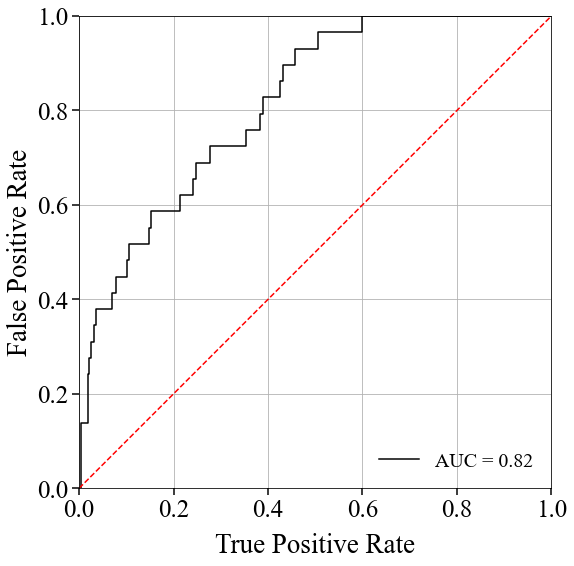

In [168]:
plot_roc(y_test, result[0][:,1])

No handles with labels found to put in legend.


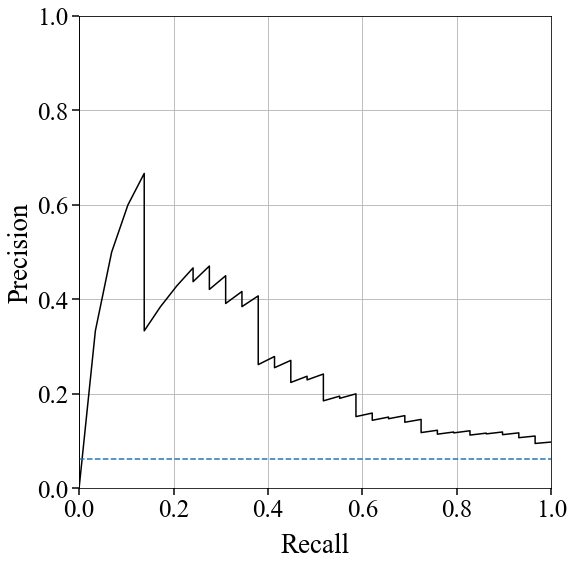

In [169]:
for i in result:
    plot_recall_precision(y_test, i[:,1])

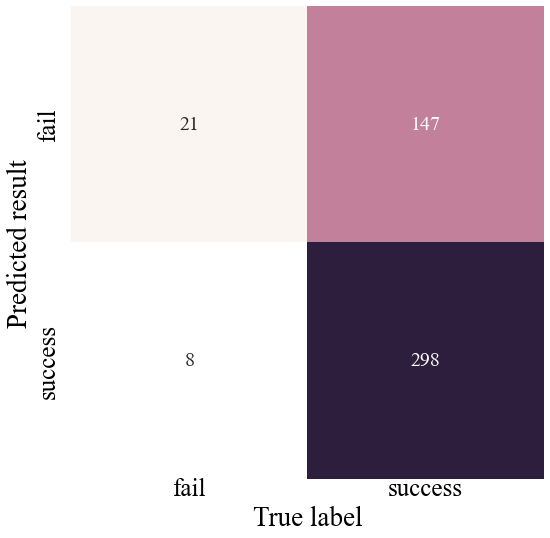

In [170]:
plot_cm(y_test, result[0][:, 1], 0.051)